In [78]:
import time
start = time.time()
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

#plotting
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

#statistics & econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm

#model fiiting and selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor, XGBClassifier

In [79]:
df = pd.read_csv("../input/stocknews/Combined_News_DJIA.csv",low_memory=False,
                    parse_dates=[0])
#use date as index
df.index = df.Date
df = df.drop(["Date"], axis=1)

full_stock = pd.read_csv("../input/stocknews/DJIA_table.csv",low_memory=False,
                    parse_dates=[0])
full_stock.index = full_stock.Date
full_stock = full_stock.drop(["Date"], axis=1)

#calculate the difference between opening and closing stock value
full_stock['Diff'] = full_stock.Close - full_stock.Open
fl_cols = list(full_stock.columns)
fl_cols = fl_cols[0:6]
full_stock = full_stock.drop(fl_cols, axis=1)

#merge the headlines together into one text
headlines = []
for row in range(0,len(df.index)):
   headlines.append(' '.join(str(x) for x in df.iloc[row,2:27]))

df['Headlines'] = headlines

#add the difference between opening and closing stock value to the df - this will be the y variable
df = df.merge(full_stock, left_index=True, right_index=True)

#drop the Label column and Top1-Top25
drop_it = df.columns
drop_it = drop_it[0:26]
df = df.drop(drop_it, axis=1)

#show how the dataset looks like
df.head(5)

,Headlines,Diff
Date,,
2008-08-08,b'BREAKING: Musharraf to be impeached.' b'Russ...,302.230468
2008-08-11,"b'Bush puts foot down on Georgian conflict' b""...",52.679687
2008-08-12,"b""Russia 'ends Georgia operation'"" b'""If we ha...",-139.230468
2008-08-13,"b""When the president ordered to attack Tskhinv...",-99.849609
2008-08-14,b'War in South Osetia - 89 pictures made by a ...,83.859376


# Data cleaning

### NA treatment
We'll simply fill the NAs in the numerical features (Date, Close). 
In the text features we'll fill the missing values with ''.

In [80]:
df = df.replace(np.nan, ' ', regex=True)

#sanity check
df.isnull().sum().sum()

0

### Remove the HTML tags and digits
There are several non-word tags in the headlines that would just bias the sentiment analysis so we need to remove them and replace with ''. This can be done with regex.

In [81]:
df = df.replace('b\"|b\'|\\\\|\\\"|\'', '', regex=True)
df = df.replace('[0-9]', '', regex=True)
df.head(5)

,Headlines,Diff
Date,,
2008-08-08,BREAKING: Musharraf to be impeached. Russia To...,302.230468
2008-08-11,Bush puts foot down on Georgian conflict Jewis...,52.679687
2008-08-12,Russia ends Georgia operation If we had no sex...,-139.230468
2008-08-13,When the president ordered to attack Tskhinval...,-99.849609
2008-08-14,War in South Osetia - pictures made by a Russ...,83.859376


In [82]:
df.shape

(1989, 2)

# Train-test split
Some of the feature extraction methods require to use separate train-test sets.

In [83]:
def ts_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [84]:
X = df.copy()
X = X.drop(['Diff'],axis=1)
y = df.Diff

In [85]:
mean = np.mean(y)
sd = np.std(y)
y = (y-mean)/sd

In [86]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size = 0.1)

#remove first 7 rows of training set to acocunt for rows that will be removed later due to lagging
X_train = X_train.drop(X_train.index[[np.arange(0,7)]])
y_train = y_train[7:len(y_train)]


#save the train-test indeces
test_idx = y_test.index

/opt/conda/lib/python3.6/site-packages/pandas/core/arrays/datetimelike.py:451: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



# Sentiment and subjectivity score extraction
Now I run the sentiment analysis extracting the compound score that goes from -0.5 (most negative) to 0.5 (most positive). I'm going to use the "dirty" texts in this part because VADER can utilize the information such as ALL CAPS, punctuation, etc. I'll also calculate the subjectivity of each headline using the TextBlob package.

Initialise the VADER analyzer.

In [87]:
Anakin = SentimentIntensityAnalyzer()

Anakin.polarity_scores(" ")

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

Write a function to save the subjectivity score directly from TextBlob function's output. Subjectivity score might detect direct quotes in the headlines and positive stuff is rarely quoted in the headline.

In [88]:
def detect_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

detect_subjectivity(" ") #should return 0

0.0

In [89]:
start_vect=time.time()
print("ANAKIN: 'Intializing the process..'")
col="Headlines"


df[col] = df[col].astype(str) # Make sure data is treated as a string
df[col+'_pos']= df[col].apply(lambda x:Anakin.polarity_scores(x)['pos'])
df[col+'_neg']= df[col].apply(lambda x:Anakin.polarity_scores(x)['neg'])
df[col+'_comp']= df[col].apply(lambda x:Anakin.polarity_scores(x)['compound'])
df[col+'_sub'] = df[col].apply(detect_subjectivity)
    
print("VADER: Vaderization completed after %0.2f Minutes"%((time.time() - start_vect)/60))

ANAKIN: 'Intializing the process..'
VADER: Vaderization completed after 1.00 Minutes


# N-grams, n=1:2

In [90]:
from sklearn.feature_extraction.text import CountVectorizer

ngrammer = CountVectorizer(ngram_range=(1, 2), lowercase=True)
n_grams_train = ngrammer.fit_transform(X_train.Headlines)
n_grams_test = ngrammer.transform(X_test.Headlines)

In [91]:
n_grams_train.shape

(1783, 410941)

We have ~344k n-grams.

In [92]:
#the text isn't required anymore
df = df.drop(col,axis=1)
df.head(5)

,Diff,Headlines_pos,Headlines_neg,Headlines_comp,Headlines_sub
Date,,,,,
2008-08-08,302.230468,0.059,0.237,-0.9977,0.277104
2008-08-11,52.679687,0.081,0.203,-0.9875,0.374806
2008-08-12,-139.230468,0.049,0.138,-0.9769,0.494074
2008-08-13,-99.849609,0.070,0.138,-0.9703,0.364021
2008-08-14,83.859376,0.089,0.212,-0.9905,0.375099


# Explorative Data Analysis

In [93]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df.index, y=df.Diff,
                    mode='lines'))
title = []
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Aug, 2008 - Jun, 2016',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig1.update_layout(xaxis_title='Date',
                   yaxis_title='Difference between opening and closing value (in $)',
                  annotations=title)
fig1.show()

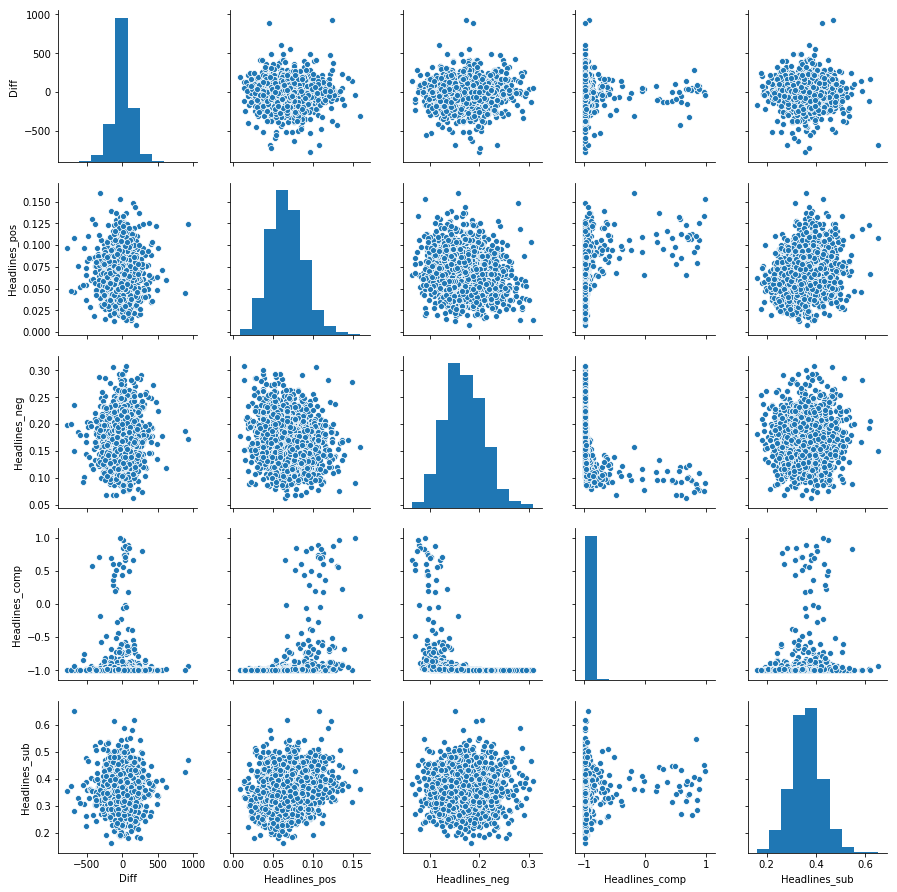

In [94]:
pairplot = sns.pairplot(df)

Next we'll look at some descriptive statistics about the data.

In [95]:
df.describe()

,Diff,Headlines_pos,Headlines_neg,Headlines_comp,Headlines_sub
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000
mean,3.916206,0.067048,0.168735,-0.955730,0.361288
std,141.227938,0.021533,0.039518,0.202475,0.062521
min,-774.169922,0.008000,0.063000,-0.999400,0.161332
25%,-60.169922,0.052000,0.141000,-0.996200,0.320411
50%,8.540039,0.065000,0.166000,-0.992800,0.360291
75%,74.558594,0.081000,0.195000,-0.984400,0.400617
max,925.190430,0.160000,0.309000,0.991000,0.651786


# Feature selection

In [96]:
def unique_ratio (col):
    return len(np.unique(col))/len(col)

cols = list(df.columns)
cols = cols[1:len(cols)]

ur = []
var = []
for col in cols:
    ur.append(unique_ratio(df[col]))
    var.append(np.var(df[col]))
    
feature_sel = pd.DataFrame({'Column': cols, 
              'Unique': ur,
              'Variance': var})
feature_sel

,Column,Unique,Variance
0,Headlines_pos,0.062846,0.000463
1,Headlines_neg,0.102061,0.001561
2,Headlines_comp,0.234791,0.040976
3,Headlines_sub,0.998492,0.003907


In [97]:
uniq_fig = go.Figure(data=go.Scatter(
    x=feature_sel.Column,
    y=feature_sel.Unique,
    mode='markers'
))
uniq_fig.update_layout( yaxis_title='Unique ratio')
uniq_fig.show()

In [98]:
var_fig = go.Figure(data=go.Scatter(
    x=feature_sel.Column,
    y=feature_sel.Variance,
    mode='markers'
))
var_fig.update_layout( yaxis_title='Variance')
var_fig.show()

In [99]:
drop = ['Headlines_pos']
clean_df = df.copy()
clean_df = clean_df.drop(drop, axis=1)

# 5. Lag the extracted features
To allow the models to look into the past, we'll add features which are essentially just copies of rows from n-steps back. In order to not create too many new features we'll add only features from 1 week prior to the current datapoint.

In [100]:
lag_df = clean_df.copy()
lag_df.head(3)

,Diff,Headlines_neg,Headlines_comp,Headlines_sub
Date,,,,
2008-08-08,302.230468,0.237,-0.9977,0.277104
2008-08-11,52.679687,0.203,-0.9875,0.374806
2008-08-12,-139.230468,0.138,-0.9769,0.494074


In [101]:
to_lag = list(lag_df.columns)
to_lag_7 = to_lag[0]
to_lag_3 = to_lag[1:len(to_lag)]

In [102]:
#lagging text features two days back
for col in to_lag_3:
    for i in range(1, 4):
        new_name = col + ('_lag_{}'.format(i))
        lag_df[new_name] = lag_df[col].shift(i)
    
#lagging closing values 7 days back
for i in range(1, 8):
    new_name = to_lag_7 + ('_lag_{}'.format(i))
    lag_df[new_name] = lag_df[to_lag_7].shift(i)

In [103]:
lag_df.head(10)

,Diff,Headlines_neg,Headlines_comp,Headlines_sub,Headlines_neg_lag_1,Headlines_neg_lag_2,Headlines_neg_lag_3,Headlines_comp_lag_1,Headlines_comp_lag_2,Headlines_comp_lag_3,Headlines_sub_lag_1,Headlines_sub_lag_2,Headlines_sub_lag_3,Diff_lag_1,Diff_lag_2,Diff_lag_3,Diff_lag_4,Diff_lag_5,Diff_lag_6,Diff_lag_7
Date,,,,,,,,,,,,,,,,,,,,
2008-08-08,302.230468,0.237,-0.9977,0.277104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-11,52.679687,0.203,-0.9875,0.374806,0.237,NaN,NaN,-0.9977,NaN,NaN,0.277104,NaN,NaN,302.230468,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-12,-139.230468,0.138,-0.9769,0.494074,0.203,0.237,NaN,-0.9875,-0.9977,NaN,0.374806,0.277104,NaN,52.679687,302.230468,NaN,NaN,NaN,NaN,NaN
2008-08-13,-99.849609,0.138,-0.9703,0.364021,0.138,0.203,0.237,-0.9769,-0.9875,-0.9977,0.494074,0.374806,0.277104,-139.230468,52.679687,302.230468,NaN,NaN,NaN,NaN
2008-08-14,83.859376,0.212,-0.9905,0.375099,0.138,0.138,0.203,-0.9703,-0.9769,-0.9875,0.364021,0.494074,0.374806,-99.849609,-139.230468,52.679687,302.230468,NaN,NaN,NaN
2008-08-15,48.690430,0.152,-0.9757,0.460870,0.212,0.138,0.138,-0.9905,-0.9703,-0.9769,0.375099,0.364021,0.494074,83.859376,-99.849609,-139.230468,52.679687,302.230468,NaN,NaN
2008-08-18,-180.260743,0.214,-0.9917,0.498768,0.152,0.212,0.138,-0.9757,-0.9905,-0.9703,0.460870,0.375099,0.364021,48.690430,83.859376,-99.849609,-139.230468,52.679687,302.230468,NaN
2008-08-19,-129.540039,0.242,-0.9961,0.345230,0.214,0.152,0.212,-0.9917,-0.9757,-0.9905,0.498768,0.460870,0.375099,-180.260743,48.690430,83.859376,-99.849609,-139.230468,52.679687,302.230468
2008-08-20,71.489258,0.198,-0.9924,0.229394,0.242,0.214,0.152,-0.9961,-0.9917,-0.9757,0.345230,0.498768,0.460870,-129.540039,-180.260743,48.690430,83.859376,-99.849609,-139.230468,52.679687


In this process, rows with NAs were created. Unfortunately these rows will have to be removed since we simply don't have the data from the future.

In [104]:
lag_df = lag_df.drop(lag_df.index[[np.arange(0,7)]])

#sanity check for NaNs
lag_df.isnull().sum().sum()

0

In [105]:
lag_df.head(10)

,Diff,Headlines_neg,Headlines_comp,Headlines_sub,Headlines_neg_lag_1,Headlines_neg_lag_2,Headlines_neg_lag_3,Headlines_comp_lag_1,Headlines_comp_lag_2,Headlines_comp_lag_3,Headlines_sub_lag_1,Headlines_sub_lag_2,Headlines_sub_lag_3,Diff_lag_1,Diff_lag_2,Diff_lag_3,Diff_lag_4,Diff_lag_5,Diff_lag_6,Diff_lag_7
Date,,,,,,,,,,,,,,,,,,,,
2008-08-19,-129.540039,0.242,-0.9961,0.345230,0.214,0.152,0.212,-0.9917,-0.9757,-0.9905,0.498768,0.460870,0.375099,-180.260743,48.690430,83.859376,-99.849609,-139.230468,52.679687,302.230468
2008-08-20,71.489258,0.198,-0.9924,0.229394,0.242,0.214,0.152,-0.9961,-0.9917,-0.9757,0.345230,0.498768,0.460870,-129.540039,-180.260743,48.690430,83.859376,-99.849609,-139.230468,52.679687
2008-08-21,14.979492,0.223,-0.9964,0.280435,0.198,0.242,0.214,-0.9924,-0.9961,-0.9917,0.229394,0.345230,0.498768,71.489258,-129.540039,-180.260743,48.690430,83.859376,-99.849609,-139.230468
2008-08-22,201.269531,0.156,-0.9678,0.314050,0.223,0.198,0.242,-0.9964,-0.9924,-0.9961,0.280435,0.229394,0.345230,14.979492,71.489258,-129.540039,-180.260743,48.690430,83.859376,-99.849609
2008-08-25,-239.940430,0.286,-0.9977,0.513259,0.156,0.223,0.198,-0.9678,-0.9964,-0.9924,0.314050,0.280435,0.229394,201.269531,14.979492,71.489258,-129.540039,-180.260743,48.690430,83.859376
2008-08-26,29.310547,0.228,-0.9894,0.380000,0.286,0.156,0.223,-0.9977,-0.9678,-0.9964,0.513259,0.314050,0.280435,-239.940430,201.269531,14.979492,71.489258,-129.540039,-180.260743,48.690430
2008-08-27,90.049805,0.180,-0.9894,0.366228,0.228,0.286,0.156,-0.9894,-0.9977,-0.9678,0.380000,0.513259,0.314050,29.310547,-239.940430,201.269531,14.979492,71.489258,-129.540039,-180.260743
2008-08-28,215.309571,0.145,-0.8910,0.234883,0.180,0.228,0.286,-0.9894,-0.9894,-0.9977,0.366228,0.380000,0.513259,90.049805,29.310547,-239.940430,201.269531,14.979492,71.489258,-129.540039
2008-08-29,-169.270508,0.128,-0.9267,0.297368,0.145,0.180,0.228,-0.8910,-0.9894,-0.9894,0.234883,0.366228,0.380000,215.309571,90.049805,29.310547,-239.940430,201.269531,14.979492,71.489258


# Time features

In [106]:
lag_df["Day"] = lag_df.index.dayofweek
lag_df["Month"] = lag_df.index.month
lag_df["Year"] = lag_df.index.year
lag_df["Quarter"] = lag_df.index.quarter

# Model training
Let's train 3(+1) ML models. We'll do this in 3 stages. First, using the econometric features alone (7 lags of y). Second, train classifiers using n_grams and topics to predict direction. Third, including the information extracted from the headlines (compound, subjectivity and their lags) and direction of the movement predicted by the classifiers from second stage.

**Models**
- Ridge regression - punish model for using too many features but doesn't allow the coeficients drop to zero completely
- SVM
- XGBoost
- Naive Bayes (only for n-grams and topics)

We'll score all models by mean squared error as it gives higher penalty to larger mistakes.
And before each model training we'll standardize the training data.

The first step will be creating folds for cross-validation. We'll use the same folds for all models in order to allow for creating a meta-model. Since we're working with timeseries the folds cannot be randomly selected. Instead a fold will be a sequence of data so that we don't lose the time information.

In [107]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

Next we split the dataset into training and testing using the indeces saved at the begining.

In [108]:
lag_df = lag_df.drop(['Diff'], axis=1)
print(min(test_idx))
X_train = lag_df[lag_df.index < min(test_idx)]
X_test = lag_df[lag_df.index >= min(test_idx)]

2015-09-18 00:00:00


And we also prepare the feature sets for each of the models. 
 - Classifier 1 - n-grams
 - Classifier 2 - sentiment and lags of y
 - Econometric - using only lags of y
 - NLP - using only sentiment and subjectivity

In [109]:
#classifier 1 - already prepared from before
#n_grams_train
#n_grams_test
X_train.columns
#classifier 2 - the same as X_train
X_train_c2 = X_train
X_test_c2 = X_test

#Econometric
drop_e = list(X_train.columns)
drop_e = drop_e[0:12]
X_train_e = X_train.drop(drop_e, axis=1)
X_test_e = X_test.drop(drop_e, axis=1)

#NLP
X_train_n = X_train[drop_e]
X_test_n = X_test[drop_e]

# Classifiers to predict direction of stock change

We need to convert the y variable to binary. 1=up or same, 0=down

In [110]:
y_train_dir = []
for i in range(0,len(y_train)):
    if y_train[i]<0: y_train_dir.append(0)
    else: y_train_dir.append(1)
        
y_test_dir = []
for i in range(0,len(y_test)):
    if y_test[i]<0: y_test_dir.append(0)
    else: y_test_dir.append(1)

And define a scorer for classifiers, we'll use balanced accuracy since there's slight imbalance in the data, no-information rate is around 0.52.

In [111]:
from sklearn.metrics import balanced_accuracy_score
scorer_class = make_scorer(balanced_accuracy_score)

Now, we're ready to fit the models

In [112]:
class_perf = pd.DataFrame(columns=['Model','Acc', 'SD'])

## Classifiers 1 - ngram

### Naive Bayes

In [113]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()

nb_param = {'alpha': list(np.arange(0,1,0.01))}
search_nb = GridSearchCV(estimator=NB,
                          param_grid = nb_param,
                          scoring = scorer_class,
                          cv = tscv,
                          n_jobs=4,
                          verbose=2
                         )
search_nb.fit(X=n_grams_train, y=y_train_dir)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   17.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=4,
             param_grid={'alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
                                   0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13,
                                   0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,
                                   0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27,
                                   0.28, 0.29, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(balanced_accuracy_score), verbose=2)

In [114]:
nb_c1 = search_nb.best_estimator_

#get cv results of the best model + confidence intervals
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(nb_c1, n_grams_train, y_train_dir, cv=tscv, scoring=scorer_class)
class_perf = class_perf.append({'Model':'NB_c1', 'Acc':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
nb_c1

MultinomialNB(alpha=0.63, class_prior=None, fit_prior=True)

### Logistic regression

In [115]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced') #using l2

lr_param = {'C': list(np.arange(0.1,1,0.1))}
search_lr = GridSearchCV(estimator=lr,
                          param_grid = lr_param,
                          scoring = scorer_class,
                          cv = tscv,
                          n_jobs=4,
                          verbose=2
                         )
search_lr.fit(n_grams_train, y_train_dir)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   17.3s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(balanced_accuracy_score), verbo

In [116]:
lr_c1 = search_lr.best_estimator_

#get cv results of the best model + confidence intervals
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(lr_c1, n_grams_train, y_train_dir, cv=tscv, scoring=scorer_class)
class_perf = class_perf.append({'Model':'Logistic Regression_c1', 'Acc':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
lr_c1

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Classifiers 2

### Naive Bayes

In [117]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [118]:
from sklearn.naive_bayes import GaussianNB
nb_c2 = GaussianNB()

nb_c2.fit(X=X_train, y=y_train_dir)

#get cv results of the best model + confidence intervals
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(nb_c2, X_train, y_train_dir, cv=tscv, scoring=scorer_class)
class_perf = class_perf.append({'Model':'NB_c2', 'Acc':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
nb_c2

GaussianNB(priors=None, var_smoothing=1e-09)

### Logistic regression

In [119]:
lr = LogisticRegression(class_weight='balanced') #using l2

lr_param = {'C': list(np.arange(0.1,1,0.1))}
search_lr = GridSearchCV(estimator=lr,
                          param_grid = lr_param,
                          scoring = scorer_class,
                          cv = tscv,
                          n_jobs=4,
                          verbose=2
                         )
search_lr.fit(X_train, y_train_dir)

lr_c2 = search_lr.best_estimator_

#get cv results of the best model + confidence intervals
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(lr_c2, X_train, y_train_dir, cv=tscv, scoring=scorer_class)
class_perf = class_perf.append({'Model':'Logistic Regression_c2', 'Acc':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
lr_c2

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.3s finished
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver

LogisticRegression(C=0.30000000000000004, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
lr_c2

LogisticRegression(C=0.30000000000000004, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Stack the classifiers with logistic regression

First we evaluate all the classifiers and decide which to use for stacking.

In [121]:
print(class_perf)

                    Model       Acc        SD
0                   NB_c1  0.505263  0.013820
1  Logistic Regression_c1  0.493432  0.035733
2                   NB_c2  0.487578  0.027937
3  Logistic Regression_c2  0.517749  0.027131


Both c2 models seem to be the most promissing, so we'll stack just these 2.

In [122]:
from sklearn.model_selection import cross_val_predict
stack = LogisticRegression(class_weight='balanced')

stack_train = pd.DataFrame(pd.DataFrame(columns=['nb_c2', 'lr_c2']))
stack_train['nb_c2'] = nb_c2.predict(X_train)
stack_train['lr_c2'] = lr_c2.predict(X_train)

stack_test = pd.DataFrame(pd.DataFrame(columns=['nb_c2', 'lr_c2']))
stack_test['nb_c2'] = nb_c2.predict(X_test)
stack_test['lr_c2'] = lr_c2.predict(X_test)


stack.fit(stack_train, y_train_dir)

pred_dir_train = cross_val_predict(stack, stack_train, y_train_dir)
pred_dir_test = stack.predict(stack_test)

#add the stack to the classifier performance table
cv_score = cross_val_score(stack, stack_train, y_train_dir, cv=tscv, scoring=scorer_class)
class_perf = class_perf.append({'Model':'Stack', 'Acc':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklea

In [123]:
class_perf

,Model,Acc,SD
0,NB_c1,0.505263,0.013820
1,Logistic Regression_c1,0.493432,0.035733
2,NB_c2,0.487578,0.027937
3,Logistic Regression_c2,0.517749,0.027131
4,Stack,0.529135,0.023879


Add these direction prediction to the data for NLP models

In [124]:
X_train_n.loc[:,'Direction'] = pred_dir_train
X_test_n.loc[:,'Direction'] = pred_dir_test

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The cost function to minimize is mean squared error because this function assigns cost proportionally to the error size. The mean absolute percentage error will be used for plotting and easier interpretation. It's much easier to understand the errors of a model in terms of percentage.
Each training set is scaled (normalized) independently to minimize data leakage.

In [125]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
scorer = make_scorer(mean_squared_error)
scaler = StandardScaler()

Function for plotting coeficients of models (lasso and XGBoost)

In [126]:
def plotCoef(model,train_x):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, train_x.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

# 8.1 Econometric models
First let's train models using only the lags of the y variable (i.e. diff).

In [127]:
econ_perf = pd.DataFrame(columns=['Model','MSE', 'SD'])

### Ridge regression

In [128]:
ridge_param = {'model__alpha': list(np.arange(1,10,0.1))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale', scaler),
    ('model', ridge)])
search_ridge = GridSearchCV(estimator=pipe,
                          param_grid = ridge_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=2
                         )
search_ridge.fit(X_train_e, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    2.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=5000,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='...
                                          2.7000000000000015,
                                          2.800000

In [129]:
ridge_e = search_ridge.best_estimator_

#get cv results of the best model + confidence intervals
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(ridge_e, X_train_e, y_train, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_e

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=5000, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

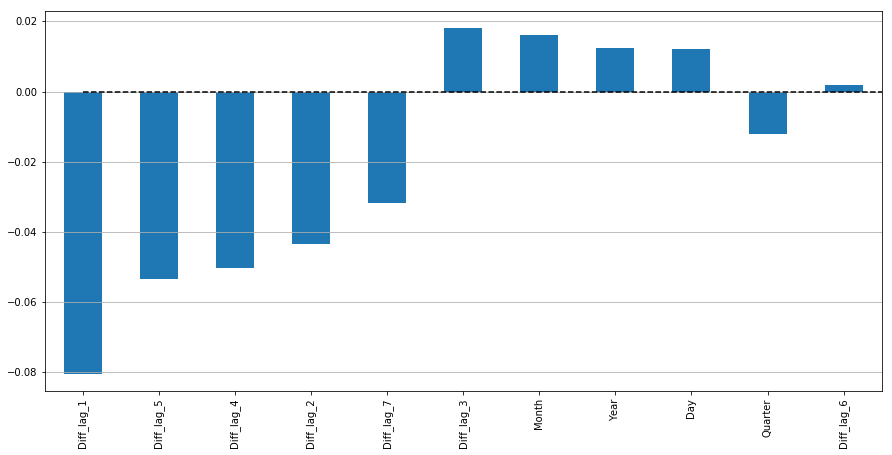

In [130]:
plotCoef(ridge_e['model'], X_train_e)

In [131]:
coefs = ridge_e['model'].coef_
ridge_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_e.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

,Coef,Name
0,-0.080494,Diff_lag_1
4,-0.053414,Diff_lag_5
3,-0.050223,Diff_lag_4
1,-0.043498,Diff_lag_2
6,-0.031685,Diff_lag_7
2,0.018146,Diff_lag_3
8,0.016254,Month
9,0.012467,Year
7,0.012259,Day
10,-0.012016,Quarter


### Random Forest

In [132]:
rf_param = {'model__n_estimators': [10, 100, 300],
            'model__max_depth': [10, 20, 30, 40],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 3],
            'model__max_features': ["auto", 'sqrt']}

rf = RandomForestRegressor()
pipe = Pipeline([
    ('scale', scaler),
    ('model', rf)])
gridsearch_rf = GridSearchCV(estimator=pipe,
                          param_grid = rf_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_rf.fit(X_train_e, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 155 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 315 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 539 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 827 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  4.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                              

In [133]:
rf_e = gridsearch_rf.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(rf_e, X_train_e, y_train, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

### XGBoost

In [134]:
xgb_param = {'model__lambda': list(np.arange(0.1,3, 0.1)), #L2 regularisation
             'model__alpha': list(np.arange(0.1,3, 0.1)),  #L1 regularisation
            }

xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe = Pipeline([
    ('scale', scaler),
    ('model', xgb)])
gridsearch_xgb = GridSearchCV(estimator=pipe,
                          param_grid = xgb_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_xgb.fit(X_train_e, y_train)

Fitting 5 folds for each of 841 candidates, totalling 4205 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 456 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 1096 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 1992 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 3144 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done 4205 out of 4205 | elapsed:  1.1min finished
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gblinear',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     feature_selector='shuffle',
                                                     gamma=0,
                               

In [135]:
xgb_e = gridsearch_xgb.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(xgb_e, X_train_e, y_train, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_e

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBRegressor(alpha=0.1, base_score=0.5, booster='gblinear',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, feature_selector='shuffle',
                              gamma=0, importance_type='gain', lambda=0.1,
                              learning_rate=0.1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=1,
                              verbosity=1))],
         verbose=False)

,Coef,Name
0,-0.039168,Diff_lag_1
4,-0.024684,Diff_lag_5
3,-0.024649,Diff_lag_4
1,-0.019927,Diff_lag_2
6,-0.015460,Diff_lag_7
2,0.012777,Diff_lag_3
7,0.006449,Day
9,0.005330,Year
5,0.004933,Diff_lag_6
8,0.001259,Month


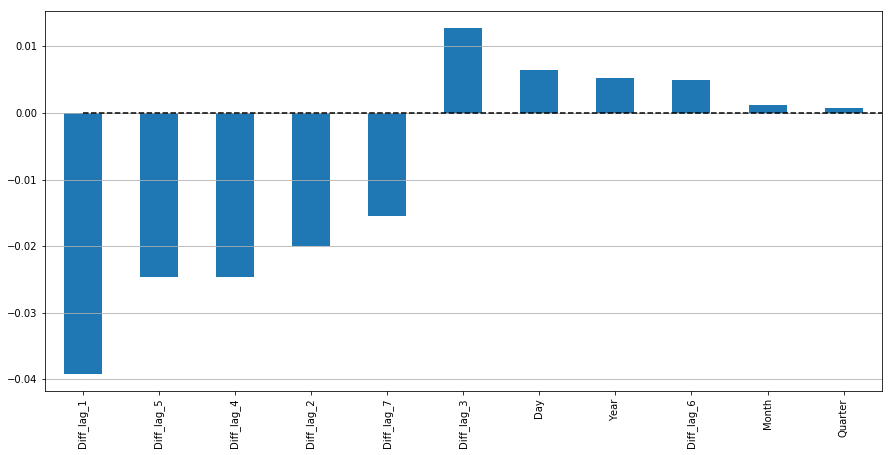

In [136]:
plotCoef(xgb_e['model'], X_train_e)

coefs = xgb_e['model'].coef_
xgb_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_e.columns)})
xgb_coefs["abs"] = xgb_coefs.Coef.apply(np.abs)
xgb_coefs = xgb_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
xgb_coefs

In [137]:
print(econ_perf)
econ_fig = px.scatter(econ_perf, x="Model", y='MSE', color='Model', error_y="SD")
econ_fig.show()

   Model       MSE        SD
0  Ridge  0.866995  0.305531
1     RF  0.865548  0.345416
2    XGB  0.746215  0.290017


## NLP models
Let's try now predict the stock value using only information from the news headlines.

In [138]:
nlp_perf = pd.DataFrame(columns=['Model','MSE', 'SD'])

### Ridge

In [139]:
ridge_param = {'model__alpha': list(np.arange(1,10,0.1))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale', scaler),
    ('model', ridge)
])
search_ridge = GridSearchCV(estimator=pipe,
                          param_grid = ridge_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4
                         )
search_ridge.fit(X_train_n, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=5000,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='...
                                          2.7000000000000015,
                                          2.800000

In [140]:
ridge_n = search_ridge.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(ridge_n, X_train_n, y_train, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_n

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=5000, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

,Coef,Name
12,0.051356,Direction
4,0.036494,Headlines_neg_lag_2
7,0.035397,Headlines_comp_lag_2
3,-0.035306,Headlines_neg_lag_1
1,-0.032720,Headlines_comp
2,-0.018816,Headlines_sub
10,0.014402,Headlines_sub_lag_2
0,0.013737,Headlines_neg
5,-0.012438,Headlines_neg_lag_3
6,-0.012400,Headlines_comp_lag_1


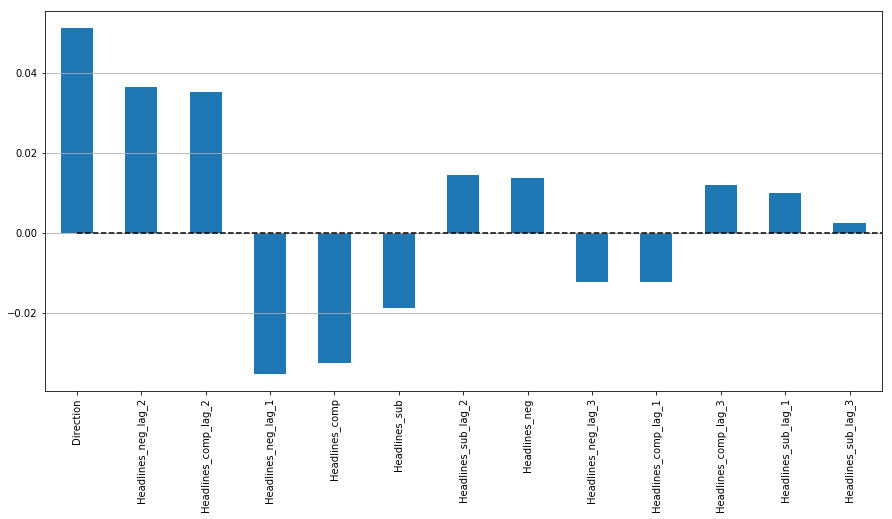

In [141]:
plotCoef(ridge_n['model'], X_train_n)

coefs = ridge_n['model'].coef_
ridge_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_n.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

### Random Forest

In [142]:
rf_param = {'model__n_estimators': [10, 100, 300],
            'model__max_depth': [10, 20, 30, 40],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 3],
            'model__max_features': ["auto", 'sqrt']}
rf = RandomForestRegressor()
pipe = Pipeline([
    ('scale', scaler),
    ('model', rf)])
gridsearch_rf = GridSearchCV(estimator=pipe,
                          param_grid = rf_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_rf.fit(X_train_n, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:   42.9s
[Parallel(n_jobs=4)]: Done 332 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 556 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 844 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  4.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                              

In [143]:
rf_n = gridsearch_rf.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(rf_n, X_train_n, y_train, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

### XGBoost

In [144]:
xgb_param = {'model__lambda': list(np.arange(1,10, 1)), #L2 regularisation
             'model__alpha': list(np.arange(1,10, 1)),  #L1 regularisation
            }
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe = Pipeline([
    ('scale', scaler),
    ('model', xgb)])
gridsearch_xgb = GridSearchCV(estimator=pipe,
                          param_grid = xgb_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_xgb.fit(X_train_n, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 104 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 405 out of 405 | elapsed:    6.8s finished
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gblinear',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     feature_selector='shuffle',
                                                     gamma=0,
                               

In [145]:
xgb_n = gridsearch_xgb.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(xgb_n, X_train_n, y_train, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_n

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBRegressor(alpha=1, base_score=0.5, booster='gblinear',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, feature_selector='shuffle',
                              gamma=0, importance_type='gain', lambda=1,
                              learning_rate=0.1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=1,
                              verbosity=1))],
         verbose=False)

,Coef,Name
12,0.029362,Direction
1,-0.016446,Headlines_comp
3,-0.016418,Headlines_neg_lag_1
4,0.016147,Headlines_neg_lag_2
7,0.014920,Headlines_comp_lag_2
2,-0.009039,Headlines_sub
10,0.008237,Headlines_sub_lag_2
5,-0.008136,Headlines_neg_lag_3
0,0.008042,Headlines_neg
8,0.006958,Headlines_comp_lag_3


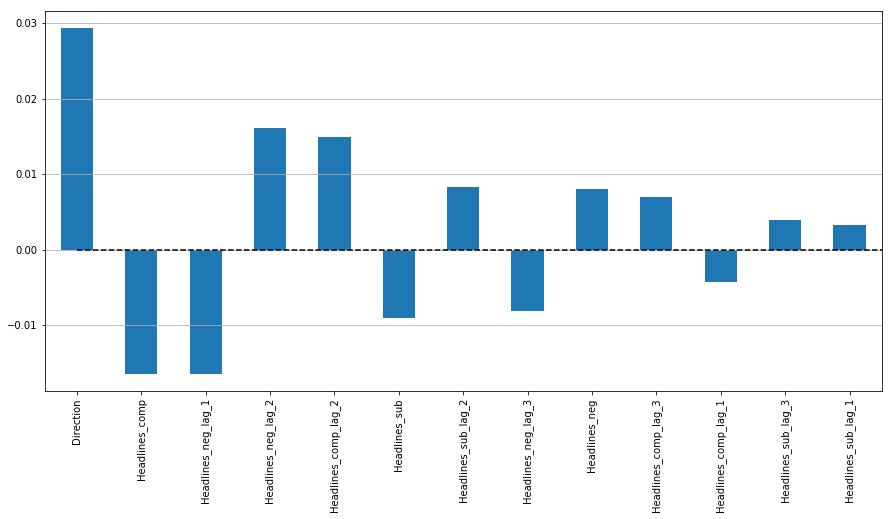

In [146]:
plotCoef(xgb_n['model'], X_train_n)

coefs = xgb_n['model'].coef_
xgb_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_n.columns)})
xgb_coefs["abs"] = xgb_coefs.Coef.apply(np.abs)
xgb_coefs = xgb_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
xgb_coefs

In [147]:
print(nlp_perf)

nlp_fig = px.scatter(nlp_perf, x="Model", y='MSE', color='Model', error_y="SD")
nlp_fig.show()

   Model       MSE        SD
0  Ridge  0.776803  0.277442
1     RF  0.926657  0.292253
2    XGB  0.742820  0.284179


### Save predictions to compare the performance and interpretation

In [148]:
prediction_compare = pd.DataFrame(pd.DataFrame(columns=['y_true', 'econ_r', 'econ_rf', 'econ_x', 'nlp_r', 'nlp_rf', 'nlp_x']))
prediction_compare['y_true'] = y_test
prediction_compare['econ_r'] = ridge_e.predict(X_test_e)
prediction_compare['econ_rf'] = rf_e.predict(X_test_e)
prediction_compare['econ_x'] = xgb_e.predict(X_test_e)
prediction_compare['nlp_r'] = ridge_n.predict(X_test_n)
prediction_compare['nlp_rf'] = rf_n.predict(X_test_n)
prediction_compare['nlp_x'] = xgb_n.predict(X_test_n)

prediction_compare.sample(5)

,y_true,econ_r,econ_rf,econ_x,nlp_r,nlp_rf,nlp_x
Date,,,,,,,
2016-06-28,1.524832,0.371179,-1.329250,0.177358,0.003851,-0.122406,0.005978
2016-05-12,0.038704,0.083529,0.207615,0.036305,0.166549,-0.039864,0.085310
2016-04-13,1.152349,-0.028673,0.183257,-0.016531,-0.065757,-0.701654,-0.037643
2016-02-03,1.037901,0.324206,0.289802,0.170942,0.046514,0.179140,0.028016
2016-01-07,-2.678444,0.239630,0.253012,0.112930,-0.029174,-0.405589,-0.010251


In [149]:
class_perf.to_csv('class_perf.csv')
econ_perf.to_csv("econ_perf.csv")
nlp_perf.to_csv("nlp_perf.csv")
prediction_compare.to_csv('compare_predictions.csv')

X_test = pd.DataFrame(data=X_test[1:,1:], 
                      index=X_test[1:,0],
                      columns=X_test[0,1:])
X_test.to_csv("X_test.csv")